In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare and Custom Data Folder

In [ ]:
!wget https://motchallenge.net/data/MOT17.zip
!unzip /content/MOT17.zip

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install ultralytics
!pip install gdown


--2024-10-28 19:40:50--  https://motchallenge.net/data/MOT17.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5860214001 (5.5G) [application/zip]
Saving to: ‘MOT17.zip’

MOT17.zip             1%[                    ]  98.27M  13.0MB/s    eta 8m 26s ^C
Archive:  /content/MOT17.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/MOT17.zip or
        /content/MOT17.zip.zip, and cannot find /content/MOT17.zip.ZIP, period.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 15.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision import transforms as transforms
from ultralytics import YOLO
from tqdm import tqdm
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def convert_to_yolo_box(bbox,img_width,img_height,format='coco'):
    '''
    parameters:
      bbox: np.ndarray[class_id,xmin,ymin,box_width,box_heigh] if type 'coco' else [class_id,xmin,ymin,xmax,ymax]
    return:
      yolo format : np.ndarray[class_id,x_center,y_center,box_width,box_height] scaled in range (0,1)
    '''
    if(format=='coco'): # xmin,ymin,width,height
      x_center=(bbox[...,1]+(bbox[...,3]/2))/img_width
      y_center=(bbox[...,2]+(bbox[...,4]/2))/img_height
      box_width=bbox[...,3]/img_width
      box_height=bbox[...,4]/img_height
    elif(format=='voc'):
      x_center=((bbox[...,1]+bbox[...,3])/2)/img_width
      y_center=((bbox[...,2]+bbox[...,4])/2)/img_height
      box_width=(bbox[...,3]-bbox[...,1])/img_width
      box_height=(bbox[...,4]-bbox[...,2])/img_height
    return np.clip(np.round(np.array([0,x_center,y_center,box_width,box_height]),6),0,1)

In [ ]:
import configparser

def make_yolo_dir(data_path,new_path):
    if(os.path.isdir(new_path)):
      shutil.rmtree(new_path)
    img_path=os.path.join(new_path,'images')
    label_path=os.path.join(new_path,'labels')

    for phrase in os.listdir(data_path):
      original_phrase_path=os.path.join(data_path,phrase)
      for fol in os.listdir(original_phrase_path):
        config = configparser.ConfigParser()
        config.read(os.path.join(original_phrase_path,fol,'seqinfo.ini'))
        img_width=int(config['Sequence']['imWidth'])
        img_height=int(config['Sequence']['imHeight'])

        original_img_path=os.path.join(original_phrase_path,fol,'img1')
        original_label_path=os.path.join(original_phrase_path,fol,'det')

        if(phrase=='train' and 'SDP' in fol):

          os.makedirs(os.path.join(img_path,'train'),exist_ok=True)
          os.makedirs(os.path.join(label_path,'train'),exist_ok=True)

          for original_img in tqdm(os.listdir(original_img_path)):
             shutil.copy2(src=os.path.join(original_img_path,original_img),dst=os.path.join(img_path,'train',f'train_{"".join(fol.split("-"))}{original_img}'))
          for id,row in tqdm(pd.read_csv(os.path.join(original_label_path,'det.txt'),names=['frame','id','xmin','ymin','width','height','visibility']).iterrows()):
              with open(os.path.join(label_path,'train',f'train_{"".join(fol.split("-"))}{int(row.loc["frame"]):06d}.txt'),"a") as f:
                  f.write(" ".join(map(str, convert_to_yolo_box(row[['id','xmin','ymin','width','height']].values,img_width,img_height))) + "\n")
        elif(phrase=='test' and 'SDP' in fol):

          os.makedirs(os.path.join(img_path,'val'),exist_ok=True)
          os.makedirs(os.path.join(label_path,'val'),exist_ok=True)

          for original_img in tqdm(os.listdir(original_img_path)):
             shutil.copy2(src=os.path.join(original_img_path,original_img),dst=os.path.join(img_path,'val',f'val_{"".join(fol.split("-"))}{original_img}'))
          for id,row in tqdm(pd.read_csv(os.path.join(original_label_path,'det.txt'),names=['frame','id','xmin','ymin','width','height','visibility']).iterrows()):
              with open(os.path.join(label_path,'val',f'val_{"".join(fol.split("-"))}{int(row.loc["frame"]):06d}.txt'),"a") as f:
                  f.write(" ".join(map(str, convert_to_yolo_box(row.loc[['id','xmin','ymin','width','height']].values,img_width,img_height))) + "\n")

        else: continue


In [ ]:
new_path='/content/new_mot17'
data_path='/content/MOT17'
config_path="/content/new_mot17/yolo_config.yaml"

make_yolo_dir(data_path,new_path)

NameError: name 'make_yolo_dir' is not defined

In [ ]:
import yaml

yaml_data={
    "path":new_path,
    "train":"images/train",
    "val":f"images/val",
    "nc":1,
    "names":[
        "person"
    ]
}

with open(config_path,'w') as f:
    yaml.dump(yaml_data,f, default_flow_style=False)

# Detector

## Train Detector

In [ ]:
model = YOLO("yolo11n.pt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs=30
bs=-1
project='/content/drive/MyDrive/yolo11'
name='log'

100%|██████████| 5.35M/5.35M [00:00<00:00, 22.5MB/s]


In [ ]:
results = model.train(data="/content/new_mot17/yolo_config.yaml", epochs=epochs, device=device,batch=bs,project=project,name=name)

engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/new_mot17/yolo_config.yaml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=/content/drive/MyDrive/yolo11, name=log, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, kera

train: Scanning /content/new_mot17/labels/train... 5310 images, 6 backgrounds, 0 corrupt: 100%|██████████| 5316/5316 [00:04<00:00, 1152.90it/s]


train: New cache created: /content/new_mot17/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/new_mot17/labels/val... 5913 images, 6 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:05<00:00, 992.76it/s]


val: New cache created: /content/new_mot17/labels/val.cache
Plotting labels to /content/drive/MyDrive/yolo11/log/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0014765625), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/yolo11/log
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      40.3G      1.724       2.24      1.199        581        640: 100%|██████████| 29/29 [00:20<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


                   all       5919     128653     0.0605      0.835      0.239       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      37.3G      1.481      1.004      1.063        654        640: 100%|██████████| 29/29 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]


                   all       5919     128653      0.875      0.512      0.703      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      37.1G      1.432      0.912      1.044        733        640: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


                   all       5919     128653      0.931      0.479      0.714       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      37.1G      1.389     0.8534      1.037        489        640: 100%|██████████| 29/29 [00:18<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


                   all       5919     128653      0.763      0.658      0.744      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      40.3G      1.354     0.8133      1.024        703        640: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


                   all       5919     128653      0.701      0.669      0.671      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      35.5G      1.318     0.7654      1.011        731        640: 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.49s/it]


                   all       5919     128653      0.822      0.798       0.86      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      33.6G      1.285     0.7252     0.9999        733        640: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]


                   all       5919     128653      0.858      0.759      0.862       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      32.4G      1.264     0.6993     0.9952        591        640: 100%|██████████| 29/29 [00:18<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


                   all       5919     128653      0.871      0.823      0.905      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      36.3G      1.246     0.6837      0.988        628        640: 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


                   all       5919     128653       0.88      0.807      0.898      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      32.7G      1.236     0.6705     0.9832        916        640: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


                   all       5919     128653      0.874       0.82      0.903      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      35.7G      1.207     0.6498     0.9766        647        640: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


                   all       5919     128653       0.88      0.804      0.893      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      32.1G      1.207     0.6446     0.9782        730        640: 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]


                   all       5919     128653       0.88      0.808      0.897      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      33.2G      1.196     0.6361     0.9723        593        640: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all       5919     128653      0.887      0.815      0.905      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      37.2G      1.197     0.6297     0.9723        611        640: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all       5919     128653      0.882      0.797      0.897      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      36.5G      1.173     0.6165     0.9664        567        640: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


                   all       5919     128653      0.887      0.813      0.898      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      32.8G      1.184     0.6202     0.9677        507        640: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all       5919     128653      0.883      0.827      0.907      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      36.2G      1.155     0.6027     0.9598        624        640: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all       5919     128653      0.898      0.799        0.9      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      30.8G      1.164     0.6029       0.96        734        640: 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


                   all       5919     128653      0.899      0.813      0.908      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      34.7G      1.143     0.5925     0.9559        608        640: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


                   all       5919     128653        0.9      0.823      0.913      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      39.1G      1.148     0.5916     0.9563        657        640: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


                   all       5919     128653        0.9      0.818      0.914      0.581
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      28.3G      1.121     0.5855      0.953        402        640: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


                   all       5919     128653      0.893      0.808      0.903      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      27.3G      1.103     0.5642     0.9456        350        640: 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all       5919     128653      0.898      0.832      0.916      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      27.3G      1.104     0.5613     0.9472        258        640: 100%|██████████| 29/29 [00:16<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


                   all       5919     128653      0.898      0.819      0.913      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      27.3G      1.088     0.5512     0.9425        359        640: 100%|██████████| 29/29 [00:16<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


                   all       5919     128653      0.899      0.831       0.92       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      27.3G      1.078     0.5414     0.9361        346        640: 100%|██████████| 29/29 [00:16<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


                   all       5919     128653      0.903      0.812      0.906      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      27.3G      1.075     0.5355     0.9371        368        640: 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]


                   all       5919     128653      0.908      0.807      0.907      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      27.2G      1.067     0.5319     0.9319        396        640: 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


                   all       5919     128653      0.906      0.821      0.914      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      27.2G      1.053     0.5239      0.929        337        640: 100%|██████████| 29/29 [00:16<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


                   all       5919     128653      0.908      0.813       0.91      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      27.3G      1.046     0.5204     0.9257        297        640: 100%|██████████| 29/29 [00:16<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


                   all       5919     128653      0.912      0.812       0.91      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      27.3G      1.035     0.5131     0.9248        429        640: 100%|██████████| 29/29 [00:16<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


                   all       5919     128653      0.908       0.81      0.909      0.594

30 epochs completed in 0.358 hours.
Optimizer stripped from /content/drive/MyDrive/yolo11/log/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/yolo11/log/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/yolo11/log/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


                   all       5919     128653      0.911      0.812       0.91      0.596
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/drive/MyDrive/yolo11/log


## Eval Detector

In [ ]:
def drawBox(img,bboxes,labels=None):
    new_img=img.copy()
    for i,box in enumerate(bboxes):
      xmin,ymin,xmax,ymax = box.astype('int')
      if(labels is None):
        labels=['']*len(bboxes)
      (label_width, label_height), baseline = cv2.getTextSize(str(labels[i]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, 1)
      new_img=cv2.rectangle(new_img, (xmin,ymin-(label_height+baseline+4)), (xmin+label_width+2,ymin), (0,255,0), thickness=cv2.FILLED)
      new_img = cv2.putText(new_img, str(labels[i]), (xmin,ymin-5),cv2.FONT_HERSHEY_SIMPLEX,
                    0.3, (0,0,0),1,cv2.LINE_AA)
      new_img = cv2.rectangle(new_img,(xmin,ymin),(xmax,ymax),color=(0,255,0))
    return new_img

In [ ]:
def plot_eval(model):
  import glob
  root_img_path=os.path.join(data_path,'test/*','img1/*jpg')
  img_path= glob.glob(root_img_path)
  fig, axs = plt.subplots(2, 3, figsize=(10, 3))
  for i in range(6):
      rand_idx=np.random.randint(0,len(img_path)-1)
      img_idx_path=img_path[rand_idx]
      pred=model(img_idx_path,verbose=False)[0].cpu().numpy()
      bboxes=pred.boxes.xyxy #voc format
      pred_original_img=pred.orig_img
      ax = axs[i // 3, i % 3]  # Tính toán vị trí axes
      ax.imshow(drawBox(pred_original_img,bboxes,pred.boxes.cls))  # Vẽ hình ảnh
      ax.axis('off')
  plt.show()

In [ ]:
trained_yolo_path=os.path.join(project,name,'weights/best.pt')
best_model=YOLO(trained_yolo_path)

In [ ]:
result = best_model.val(project=project,name='log/val')

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/new_mot17/labels/val.cache... 5913 images, 6 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 370/370 [00:47<00:00,  7.78it/s]


                   all       5919     128653      0.911      0.812       0.91      0.596
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/drive/MyDrive/yolo11/log/val


**mAP@50 score: 0.912 cho thấy mô hình đã khá tốt cho việc phát hiện bndbox với mức IoU >50%**

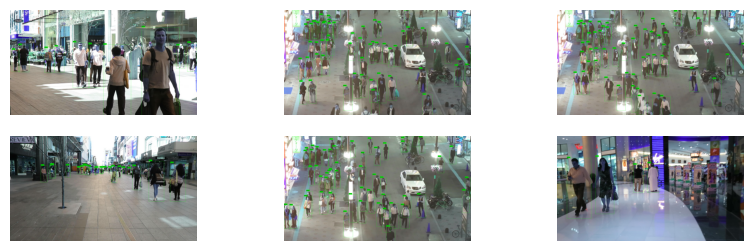

In [ ]:
plot_eval(best_model)

## Define Detector Class

In [ ]:
class Detector:
    def __init__(self,model_path):
        self.model=YOLO(model_path)
    def detect(self,img_path):
        pred=self.model(img_path,verbose=False)[0].cpu().numpy()
        bboxes=pred.boxes.xywh
        bboxes[:,:2]=bboxes[:,:2]-(bboxes[:,2:]/2)
        scores=pred.boxes.conf
        class_ids=pred.boxes.cls
        return bboxes,scores,class_ids

In [ ]:
# test_detector=Detector(trained_yolo_path)
# test_detector.detect('/content/MOT17/test/MOT17-01-DPM/img1/000001.jpg')

# Tracker

## Download DeepSORT(Pretrained-Mracking-Model) and it's encoder (Pretrained-CNN-Model)

In [ ]:
if(os.path.isdir('/content/deep_sort')):
  shutil.rmtree('/content/deep_sort')
!git clone https://github.com/PDuy2k4/deep_sort.git
!gdown --no-check-certificate 1bB66hP9voDXuoBoaCcKYY7a8IYzMMs4P

Cloning into 'deep_sort'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 59 (delta 24), reused 50 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 44.52 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-0g-1c-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Downloading...
From

## Define DeepSORT

In [ ]:
from deep_sort.deep_sort.nn_matching import NearestNeighborDistanceMetric
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.detection import Detection
from deep_sort.tools.generate_detections import create_box_encoder

In [ ]:
class DeepSORT:
  def __init__(self,encoder_path,metric_type="cosine",matching_threshold=0.7):
      self.encoder=create_box_encoder(encoder_path,batch_size=1) # track từng frame nên chỉ nhận 1 ảnh
      self.tracker_module=Tracker(metric=NearestNeighborDistanceMetric(metric_type,matching_threshold))
  def tracking(self,img,bboxes,scores,class_ids):
      extracted_features=self.encoder(img,bboxes)
      detections=[
          Detection(bboxe,score,extracted_feature,class_id)\
          for bboxe,score,extracted_feature,class_id\
          in zip(bboxes,scores,extracted_features,class_ids)
      ]
      self.tracker_module.predict()
      self.tracker_module.update(detections)

      tracking_list=[]
      for track in self.tracker_module.tracks:
          if not track.is_confirmed() or track.time_since_update>10: continue #10 frame không cập nhật nên vật đó có thể đã ra khỏi khung ảnh nên không track nữa
          tracking_id=track.track_id
          tracking_cls=track.get_class_id()
          tracking_confs=track.get_confs()
          tracking_box=track.to_tlbr().tolist()
          tracking_list.append([tracking_id]+tracking_cls+tracking_confs+tracking_box)
      return tracking_list


# Test trên video

In [ ]:
from google.colab.patches import cv2_imshow

def create_track_video(video_path,detector,tracker,save=True,save_dir='track_video'):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps=int(cap.get(cv2.CAP_PROP_FPS))
    if(save):
      if(os.path.isdir(os.path.join(save_dir,'output.avi'))):
        shutil.rmtree(os.path.join(save_dir,'output.avi'))
      os.makedirs(save_dir,exist_ok=True)
      fourcc = cv2.VideoWriter_fourcc(*'XVID')
      out = cv2.VideoWriter(os.path.join(save_dir,'output.avi'), fourcc, fps, (frame_width, frame_height))
    tracked_ids=[]
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        bboxes,scores,class_ids=detector.detect(frame)
        tracking_list=tracker.tracking(frame,bboxes,scores,class_ids)
        if(len(tracking_list)!=0):
          tracking_list=np.array(tracking_list)
          tracking_bboxes=tracking_list[...,-4:]
          tracking_cls=tracking_list[...,1]
          tracking_ids=tracking_list[...,0]

          tracked_ids.extend(tracking_ids)

          labels=['track_id: '+str(tracking_ids[i])+' class_id: '+ str(tracking_cls[i]) for i in range(len(tracking_ids))]
          painted_img=drawBox(frame,tracking_bboxes,labels)
        else:
          painted_img=frame
        cv2_imshow(painted_img)
        if(save): out.write(painted_img)
        if cv2.waitKey(1) == ord('q'):
            break
    if(save):out.release()
    tracked_ids=list(set(tracked_ids))
    cap.release()
    cv2.destroyAllWindows()
    return tracked_ids

In [ ]:
encoder_path='/content/mars-small128.pb'
detector=Detector(trained_yolo_path)
tracker=DeepSORT(encoder_path)

In [ ]:
!gdown https://videos.pexels.com/video-files/3552510/3552510-sd_640_360_30fps.mp4
#Tải video thử nghiệm vì detector ở trên đc train tìm object là người nên phải tải video có liên quan tới người cụ thể video này có chủ đề về người đi bộ

Downloading...
From: https://videos.pexels.com/video-files/3552510/3552510-sd_640_360_30fps.mp4
To: /content/3552510-sd_640_360_30fps.mp4
100% 1.94M/1.94M [00:00<00:00, 76.6MB/s]


In [ ]:
video_path='/content/3552510-sd_640_360_30fps.mp4'
save_dir='/content/track_video'
tracked_ids=create_track_video(
    video_path=video_path,
    detector=detector,
    tracker=tracker,
    save_dir=save_dir,
    save=True
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install moviepy

## Convert avi file to mp4 file for colab showing

In [ ]:
from moviepy.editor import VideoFileClip

# Đọc file AVI
clip = VideoFileClip(os.path.join(save_dir,"output.avi"))

# Lưu thành file MP4
clip.write_videofile(os.path.join(save_dir,"output.mp4"), codec="libx264")

  if event.key is 'enter':



Moviepy - Building video /content/track_video/output.mp4.
Moviepy - Writing video /content/track_video/output.mp4



Moviepy - Done !
Moviepy - video ready /content/track_video/output.mp4


## Show

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(os.path.join(save_dir,"output.mp4"),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.